In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, RidgeCV
import networkx as nx
from dowhy import gcm

ModuleNotFoundError: No module named 'networkx'

# Outputs for article

### VIF

\begin{align*} {VIF}(X_j) &= \frac{1}{1 - R_j^2} \end{align*}

### Marketing spend following demand

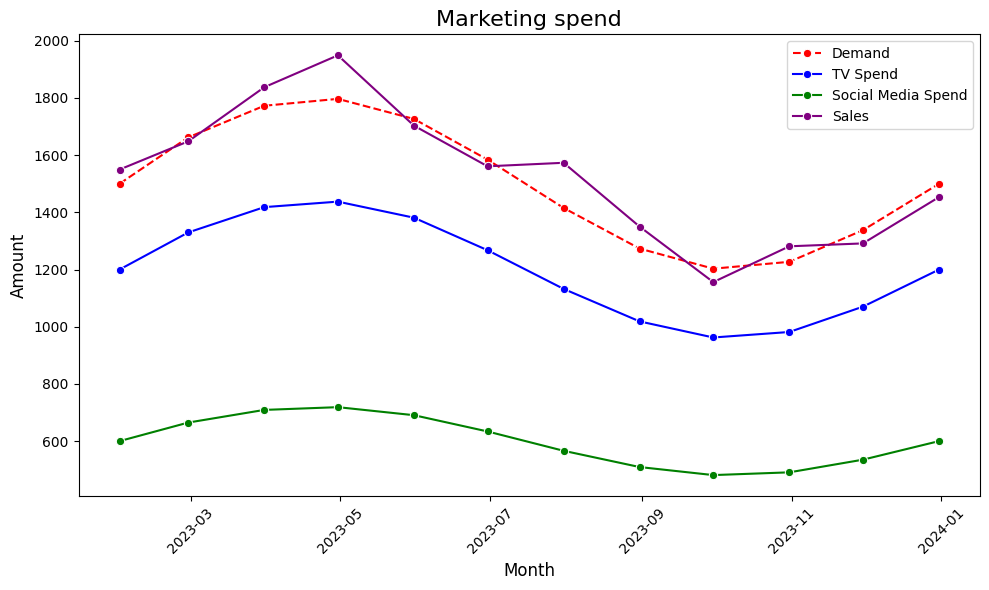

In [2]:
# Generate example data (e.g., monthly demand, spend, and sales for 12 months)
np.random.seed(42)
months = pd.date_range(start='2023-01-01', periods=12, freq='M')

# Generate a simple demand curve
demand = 1500 + 300 * np.sin(np.linspace(0, 2 * np.pi, 12))

# TV and Social Spend follow demand almost exactly
tv_spend = demand * 0.8
social_spend = demand * 0.4

# Sales follow demand but with some random noise
sales = demand + np.random.normal(0, 100, size=len(demand))

# Create DataFrame
df = pd.DataFrame({
    'Month': months, 
    'Demand': demand, 
    'TV Spend': tv_spend, 
    'Social Media Spend': social_spend, 
    'Sales': sales
})

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(x='Month', y='Demand', data=df, label='Demand', marker='o', color='red', linestyle='--')
sns.lineplot(x='Month', y='TV Spend', data=df, label='TV Spend', marker='o', color='blue')
sns.lineplot(x='Month', y='Social Media Spend', data=df, label='Social Media Spend', marker='o', color='green')
sns.lineplot(x='Month', y='Sales', data=df, label='Sales', marker='o', color='purple')

# Add chart title and labels
plt.title('Marketing spend', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Amount', fontsize=12)
plt.xticks(rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


### Simple examples

In [3]:
# example 1 - marketing spend on each channel is equal: biased coefficients
np.random.seed(150)

tv_spend = np.random.normal(0, 50, 1000)
social_spend = tv_spend
sales = 0.10 * tv_spend + 0.20 * social_spend
X = np.column_stack((tv_spend, social_spend))
clf = LinearRegression()
clf.fit(X, sales)

print(f'Coefficients: {clf.coef_}')


Coefficients: [0.13094661 0.16905339]


In [4]:
# example 2 - marketing spend on each channel follows the same trend: biased coefficients and sign flip
np.random.seed(150)

tv_spend = np.random.normal(0, 50, 1000)
social_spend = tv_spend * 0.50
sales = 0.10 * tv_spend + 0.20 * social_spend
X = np.column_stack((tv_spend, social_spend))
clf = LinearRegression()
clf.fit(X, sales)

print(f'Coefficients: {clf.coef_}')

Coefficients: [ 0.23268565 -0.0653713 ]


In [5]:
# example 3 - random noise added to marketing spend: correct coefficients
np.random.seed(150)

tv_spend = np.random.normal(0, 50, 1000)
social_spend = tv_spend * 0.50 + np.random.normal(0, 1, 1000)
sales = 0.10 * tv_spend + 0.20 * social_spend
X = np.column_stack((tv_spend, social_spend))
clf = LinearRegression()
clf.fit(X, sales)

print(f'Coefficients: {clf.coef_}')

Coefficients: [0.1 0.2]


### Causal graph

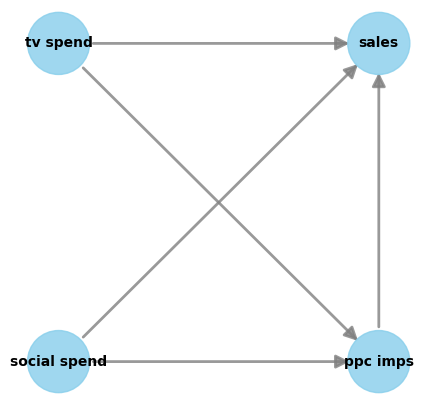

In [6]:
# Create node lookup for channels
node_lookup = {0: 'sales',
               1: 'ppc imps',
               2: 'tv spend', 
               3: 'social spend',
 }

total_nodes = len(node_lookup)

# Create adjacency matrix - this is the base for our graph
graph_actual = np.zeros((total_nodes, total_nodes))

# Create graph using expert domain knowledge
graph_actual[1, 0] = 1.0 # ppc imps -> sales
graph_actual[2, 1] = 1.0 # tv spend -> ppc imps
graph_actual[3, 1] = 1.0 # social spend -> ppc imps
graph_actual[2, 0] = 1.0 # tv spend -> sales
graph_actual[3, 0] = 1.0 # social spend -> sales
     
graph = nx.from_numpy_array(graph_actual, create_using=nx.DiGraph)
graph = nx.relabel_nodes(graph, node_lookup)
gcm.util.plot(graph, figure_size=(5,5))

# Case study

### Data generating process

In [3]:
def data_generator(spend_rand_change, true_coef):
    '''
    Generate simulated marketing data with demand, forecasted demand, social and TV spend, and sales.

    Args:
        spend_rand_change (float): Random variation parameter for marketing spend.
    true_coef (list): True coefficients for demand, social media spend, and TV spend effects on sales.

    Returns:
        pd.DataFrame: DataFrame containing the simulated data.
    '''
    
    # Parameters for data generation
    start_date = "2018-01-01"
    periods = 365 * 3  # Daily data for three years
    trend_slope = 0.01  # Linear trend component
    seasonal_amplitude = 5  # Amplitude of the seasonal component
    seasonal_period = 30.44  # Monthly periodicity
    noise_level = 5  # Level of random noise in demand

    # Generate time variables
    time = np.arange(periods)
    date_range = pd.date_range(start=start_date, periods=periods)

    # Create demand components
    trend_component = trend_slope * time
    seasonal_component = seasonal_amplitude * np.sin(2 * np.pi * time / seasonal_period)
    noise_component = noise_level * np.random.randn(periods)

    # Combine to form demand series
    demand = 100 + trend_component + seasonal_component + noise_component

    # Initialize DataFrame
    df = pd.DataFrame({'date': date_range, 'demand': demand})

    # Add forecasted demand with slight random variation
    df['demand_forecast'] = df['demand'] * np.random.uniform(0.95, 1.05, len(df))

    # Simulate social media and TV spend with random variation
    df['social_spend'] = df['demand_forecast'] * 10 * np.random.uniform(1 - spend_rand_change, 1 + spend_rand_change, len(df))
    df['tv_spend'] = df['demand_forecast'] * 20 * np.random.uniform(1 - spend_rand_change, 1 + spend_rand_change, len(df))
    df['total_spend'] = df['social_spend'] + df['tv_spend']

    # Calculate sales based on demand, social, and TV spend, with some added noise
    df['sales'] = (
        df['demand'] * true_coef[0] + 
        df['social_spend'] * true_coef[1] + 
        df['tv_spend'] * true_coef[2]
    )
    sales_noise = 0.01 * df['sales'] * np.random.randn(len(df))
    df['sales'] += sales_noise
    
    return df


### Functions

In [4]:
def calc_vif(df, features):
    
    vif_data = pd.DataFrame()
    vif_data['feature'] = features
    vif_data['VIF'] = [variance_inflation_factor(df[features].values, i) for i in range(df[features].shape[1])]
    
    print(vif_data)
    
    return vif_data

In [6]:
def run_reg(df, features, target):
    '''
    Runs a linear regression on the specified features to predict the target variable.

    Args:
        df (pd.DataFrame): The input data containing features and target.
    features (list): List of column names to be used as features in the regression.
    target (str): The name of the target column to be predicted.
    Returns:
        np.ndarray: Array of recovered coefficients from the linear regression model.
    '''
    
    # Extract features and target values
    X = df[features].values
    y = df[target].values

    # Initialize and fit linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Output recovered coefficients
    coefficients = model.coef_
    print(f'Recovered coefficients: {coefficients}')
    
    return coefficients


### Initial assessment

In [8]:
features = [
    "demand",
    "social_spend",
    "tv_spend"
]

target = "sales"

true_coef = [0.35, 0.15, 0.05]

In [10]:
np.random.seed(40)

sim_1 = data_generator(0.00, true_coef)
reg_1 = run_reg(sim_1, features, target)

print(f"True coefficients: {true_coef}")

Recovered coefficients: [0.36885221 0.04964525 0.0992905 ]
True coefficients: [0.35, 0.15, 0.05]


In [11]:
calc_vif(sim_1, features)

        feature          VIF
0        demand  1157.784242
1  social_spend          inf
2      tv_spend          inf


c:\Users\ryan.sullivan\OneDrive - Entain Group\Documents\ryan\repo\personal\pymc_marketing\venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\ryan.sullivan\OneDrive - Entain Group\Documents\ryan\repo\personal\pymc_marketing\venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,demand,1157.784242
1,social_spend,inf
2,tv_spend,inf


### Random budget adjustments

Recovered coefficients: [0.36885221 0.04964525 0.0992905 ]
Recovered coefficients: [0.38198753 0.04292777 0.10267946]
Recovered coefficients: [0.38006306 0.06050836 0.09391193]
Recovered coefficients: [0.33243726 0.11895912 0.06647406]
Recovered coefficients: [0.31299537 0.19680526 0.02803534]
Recovered coefficients: [0.30199189 0.18021112 0.03619405]
Recovered coefficients: [0.34022195 0.14365591 0.05466986]
Recovered coefficients: [0.3590875  0.17222524 0.03884952]
Recovered coefficients: [0.31699373 0.1520928  0.05078077]
Recovered coefficients: [0.34315431 0.15477287 0.04814152]
Recovered coefficients: [0.31046919 0.16487667 0.04432257]
Recovered coefficients: [0.27169987 0.14631788 0.05527722]
Recovered coefficients: [0.30084643 0.14640284 0.05278075]
Recovered coefficients: [0.3044931  0.15065851 0.05165509]
Recovered coefficients: [0.35423623 0.1480675  0.05166764]
Recovered coefficients: [0.40016502 0.14148753 0.05294333]
Recovered coefficients: [0.32821645 0.14930689 0.0497954

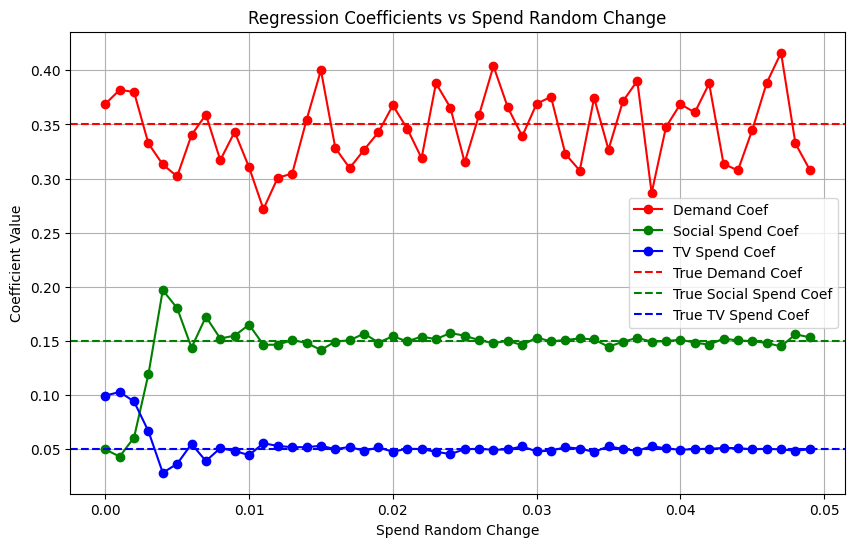

In [20]:
np.random.seed(40)

# Define list to store results
results = []

# Loop through a range of random adjustments to spend
for spend_rand_change in np.arange(0.00, 0.05, 0.001):
    # Generate simulated data with the current spend_rand_change
    sim_data = data_generator(spend_rand_change, true_coef)
    
    # Run the regression
    coefficients = run_reg(sim_data, features=['demand', 'social_spend', 'tv_spend'], target='sales')
    
    # Store the spend_rand_change and coefficients for later plotting
    results.append({
        'spend_rand_change': spend_rand_change,
        'coef_demand': coefficients[0],
        'coef_social_spend': coefficients[1],
        'coef_tv_spend': coefficients[2]
    })

# Convert results to DataFrame for easy plotting
results_df = pd.DataFrame(results)

# Plot the coefficients as a function of spend_rand_change
plt.figure(figsize=(10, 6))
plt.plot(results_df['spend_rand_change'], results_df['coef_demand'], label='Demand Coef', color='r', marker='o')
plt.plot(results_df['spend_rand_change'], results_df['coef_social_spend'], label='Social Spend Coef', color='g', marker='o')
plt.plot(results_df['spend_rand_change'], results_df['coef_tv_spend'], label='TV Spend Coef', color='b', marker='o')

# Add lines for the true coefficients
plt.axhline(y=true_coef[0], color='r', linestyle='--', label='True Demand Coef')
plt.axhline(y=true_coef[1], color='g', linestyle='--', label='True Social Spend Coef')
plt.axhline(y=true_coef[2], color='b', linestyle='--', label='True TV Spend Coef')

plt.title('Regression Coefficients vs Spend Random Change')
plt.xlabel('Spend Random Change')
plt.ylabel('Coefficient Value')
plt.legend()
plt.grid(True)
plt.show()
